# <center>Partie Statistique - Regression linéaire<br> <br> </center>
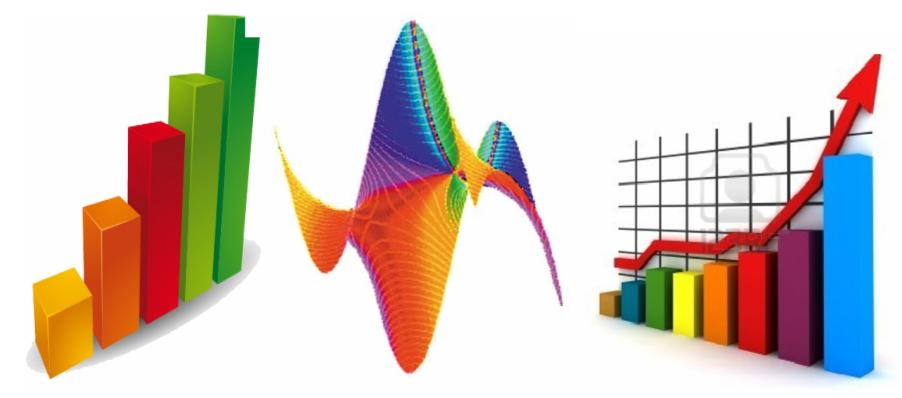

<div style="text-align:right">
    <em>Groupe 1</em>
</div>

In [62]:
from pymongo import MongoClient
from pprint import pprint
import datetime

# Connexion à la base de données, pour faire les statistiques 
client = MongoClient('localhost', 27017)
db = client['DataProject']
collection_trafic_stamped = db['vehicules_stamped']

In [71]:
import matplotlib.pyplot as plt
import matplotlib.dates as plt_dates
import numpy as np 
from statsmodels.stats.weightstats import ztest
import pandas as pd

# Lister le trafic par rapport à la date 
vehicules_par_tranche = list(collection_trafic_stamped.aggregate([
    {"$project":{"temps":{"heures":{"$hour":"$date"}, 
                          "minutes":{"$minute":"$date"}},
                 "num_arete":1,
                 "nb_vehicules":1}},
    {"$group":{"_id":{"heures":"$temps.heures", "minutes":"$temps.minutes"}, 
               "nb_vehicules":{"$avg":"$nb_vehicules"}}},
    {"$sort":{"_id":1}}
]))

# Initialiser les données pandas 
data = pd.DataFrame(vehicules_par_tranche)
data.head()

,_id,nb_vehicules
0,"{'heures': 7, 'minutes': 1}",29.9768
1,"{'heures': 7, 'minutes': 2}",30.9452
2,"{'heures': 7, 'minutes': 3}",30.9260
3,"{'heures': 7, 'minutes': 4}",31.7464
4,"{'heures': 7, 'minutes': 5}",32.8132


In [72]:
# Récupérer que le trafic de la liste  
trafic_total = np.array(data['nb_vehicules'])

# Récupérer que les dates de la liste (en objet datetime)
dates = [datetime.datetime(2015, 1, 1, document['_id']['heures'], document['_id']['minutes']) for document in vehicules_par_tranche]

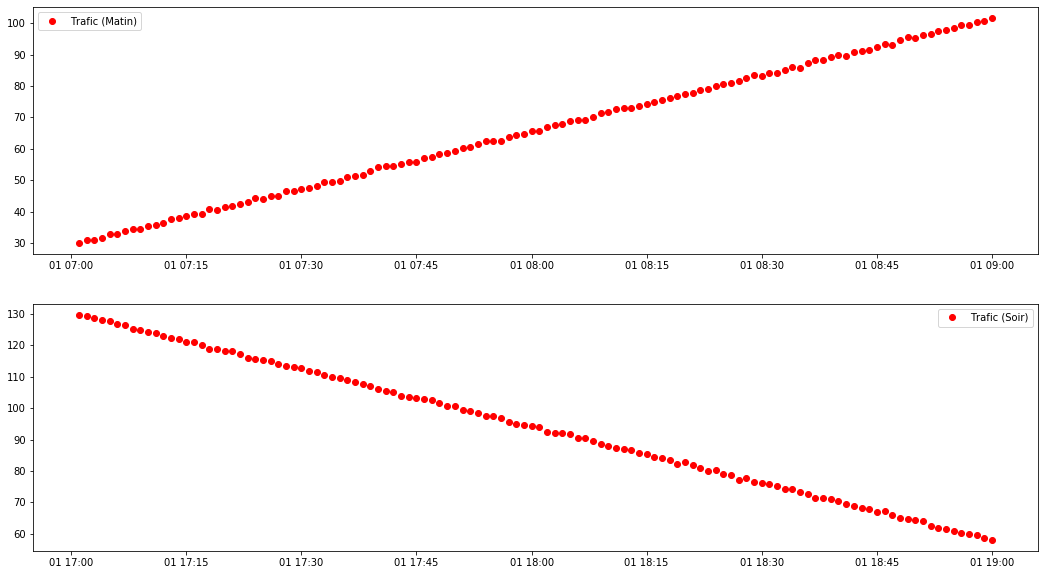

In [83]:
# Dessiner et afficher les points
fig, subplots = plt.subplots(2)

subplots[0].plot(dates[:120], trafic_total[:120], 'ro', label='Trafic (Matin)')
subplots[0].legend()

subplots[1].plot(dates[120:], trafic_total[120:], 'ro', label='Trafic (Soir)')
subplots[1].legend()

plt.gcf().set_size_inches(18, 10)
plt.show()

<h1>Notre Régression Linéaire</h1>

In [125]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Trafic du matin seulement 
temps_matin = np.expand_dims([date.hour * 60 + date.minute for date in dates[:120]], axis=-1)
trafic_matin = trafic_total[:120]

# Trafic du soir seulement 
temps_soir = np.expand_dims([date.hour * 60 + date.minute for date in dates[120:]], axis=-1)
trafic_soir = trafic_total[120:]

# Liste des regressions linéaires (matin et soir) 
linear_regression = []
linear_regression.append(LinearRegression()) 
linear_regression.append(LinearRegression()) 

# Fit 
linear_regression[0].fit(temps_matin, trafic_matin)
linear_regression[1].fit(temps_soir, trafic_soir)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [129]:
# Prediction des deux regressions linéaires 
pred_matin = linear_regression[0].predict(temps_matin)
pred_soir = linear_regression[1].predict(temps_soir)

In [143]:
# ------- PREDICTION DU MATIN ----------

#Afficher les paramètres trouvés 
print('----------- PREDICTION DU MATIN -----------')
print('Paramètres trouvés :')
print('Notre fonction de régression linéaire sera de la forme : n_voiture = slope * temps + intercept \n avec : ')
print('Slope : {}'.format(linear_regression[0].coef_[0]))
print('Intercept : {}'.format(linear_regression[0].intercept_))
print('')
    
#Afficher la performance de la régression linéaire
print('Avec une performance : ')

mse_sklearn = mean_squared_error(trafic_matin, pred_matin)
r2_sklearn= r2_score(trafic_matin, pred_matin)

# The mean squared error
print('Erreur quadratique moyenne (MSE) : {:.2f}'.format(mse_sklearn))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient de détermination R² {:.2f}'.format(r2_sklearn))


print('')

# ------- PREDICTION DU SOIR ----------

# Afficher les paramètres trouvés 
print('----------- PREDICTION DU SOIR ----------- ')
print('Paramètres trouvés :')
print('Notre fonction de régression linéaire sera de la forme : n_voiture = slope * temps + intercept \n avec : ')
print('Slope : {}'.format(linear_regression[1].coef_[0]))
print('Intercept : {}'.format(linear_regression[1].intercept_))
print('')

#Afficher la performance de la régression linéaire
print('Avec une performance : ')

mse_sklearn = mean_squared_error(trafic_soir, pred_soir)
r2_sklearn= r2_score(trafic_soir, pred_soir)

# The mean squared error
print('Erreur quadratique moyenne (MSE) : {:.2f}'.format(mse_sklearn))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient de détermination R² {:.2f}'.format(r2_sklearn))

----------- PREDICTION DU MATIN -----------
Paramètres trouvés :
Notre fonction de régression linéaire sera de la forme : n_voiture = slope * temps + intercept 
 avec : 
Slope : 0.6013736078894368
Intercept : -223.22586192420778

Avec une performance : 
Erreur quadratique moyenne (MSE) : 0.09
Coefficient de détermination R² 1.00

----------- PREDICTION DU SOIR ----------- 
Paramètres trouvés :
Notre fonction de régression linéaire sera de la forme : n_voiture = slope * temps + intercept 
 avec : 
Slope : -0.6029574456559483
Intercept : 745.4683633645856

Avec une performance : 
Erreur quadratique moyenne (MSE) : 0.09
Coefficient de détermination R² 1.00


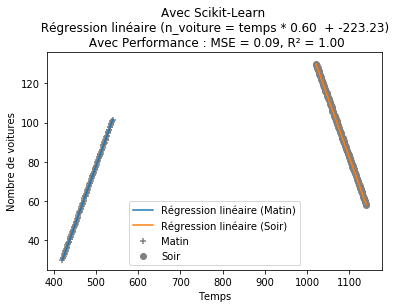

In [145]:
# Dessinons la droite de la regression linéaire pour le matin
plt.scatter(temps_matin, trafic_matin,  color='gray', marker='+', label='Matin')
plt.plot(temps_matin, pred_matin, label='Régression linéaire (Matin)')
plt.xlabel('Temps')
plt.ylabel('Nombre de voitures')
plt.title('Avec Scikit-Learn \n Régression linéaire (n_voiture = temps * {:.2f}  + {:.2f}) \n Avec Performance : MSE = {:.2f}, R² = {:.2f}'.format(reg_sklearn.coef_[0], reg_sklearn.intercept_, mse_sklearn, r2_sklearn))
plt.legend()

# Dessinons la droite de la regression linéaire pour le soir
plt.scatter(temps_soir, trafic_soir,  color='gray', marker='o', label='Soir')
plt.plot(temps_soir, pred_soir, label='Régression linéaire (Soir)')
plt.xlabel('Temps')
plt.ylabel('Nombre de voitures')
plt.title('Avec Scikit-Learn \n Régression linéaire (n_voiture = temps * {:.2f}  + {:.2f}) \n Avec Performance : MSE = {:.2f}, R² = {:.2f}'.format(reg_sklearn.coef_[0], reg_sklearn.intercept_, mse_sklearn, r2_sklearn))
plt.legend()

In [142]:
# Faisons des prédictions avec notre modèle 
exemples_matin = [540, 670]
exemples_soir = [915, 1050]

for i in range (len(exemples_matin)): 
    print(str(exemples_matin[i]) + ' -> ', end = " ")
    print(linear_regression[0].predict([[exemples_matin[i]]]))
    
for i in range (len(exemples_soir)): 
    print(str(exemples_soir[i]) + ' -> ', end = " ")
    print(linear_regression[1].predict([[exemples_soir[i]]]))

540 ->  [101.51588634]
670 ->  [179.69445536]
915 ->  [193.76230059]
1050 ->  [112.36304543]
